# Day3で学んだ決定木，ランダムフォレスタ，アダブースト，NNを使ってkickstarter-projectが成功するか予測

In [10]:
from six import StringIO
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import graphviz
import pydotplus
from IPython.display import Image

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix, precision_recall_fscore_support

In [11]:
# Day1で作成したkickstarterプロジェクトのcsvファイルを読み込む
df_kickstarter = pd.read_csv("ks-projects-201801_day1.csv")
df_kickstarter = df_kickstarter.drop("Unnamed: 0", axis=1)

In [12]:
df_kickstarter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 295703 entries, 0 to 295702
Data columns (total 20 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   state               295703 non-null  int64  
 1   usd_goal_real       295703 non-null  float64
 2   period              295703 non-null  float64
 3   period_band         295703 non-null  int64  
 4   usd_goal_real_band  295703 non-null  int64  
 5   Art                 295703 non-null  int64  
 6   Comics              295703 non-null  int64  
 7   Crafts              295703 non-null  int64  
 8   Dance               295703 non-null  int64  
 9   Design              295703 non-null  int64  
 10  Fashion             295703 non-null  int64  
 11  Film & Video        295703 non-null  int64  
 12  Food                295703 non-null  int64  
 13  Games               295703 non-null  int64  
 14  Journalism          295703 non-null  int64  
 15  Music               295703 non-nul

### band + 決定木

In [31]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz

y = df_kickstarter["state"].values
# bandを使って予測
X = df_kickstarter.drop(["state", "usd_goal_real", "period"], axis=1).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)

clf = DecisionTreeClassifier(criterion="gini", max_depth=None, min_samples_split=500, min_samples_leaf=500, random_state=1234)
clf.fit(X_train, y_train)
print("score = ", clf.score(X_train, y_train))


score =  0.6251980752879338


[0.12878968 0.3255352  0.00590706 0.03560312 0.03810005 0.01065638
 0.01018896 0.06549164 0.00507576 0.03549623 0.00573278 0.0255042
 0.10982825 0.03149207 0.03513671 0.05003797 0.08142393]


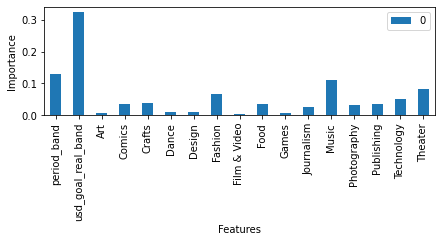

In [32]:
print(clf.feature_importances_)
pd.DataFrame(clf.feature_importances_, index=df_kickstarter.drop(["state", "usd_goal_real", "period"], axis=1).columns).plot.bar(figsize=(7,2))
plt.ylabel("Importance")
plt.xlabel("Features")
plt.show()

In [33]:
y_est = clf.predict(X_test)
y_est_proba = clf.predict_proba(X_test)
print("対数尤度 = {:.3f}".format(-log_loss(y_test, y_est_proba, normalize=False)))
print("正答率 = {:.3f}%".format(100 * accuracy_score(y_test, y_est)))

対数尤度 = -57138.355
正答率 = 62.503%


In [34]:
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_est), index=["正解 = failed", "正解 = successful"], columns=["予測値 = failed", "予測値 = successful"])
display(conf_mat)

,予測値 = failed,予測値 = successful
正解 = failed,38957,11497
正解 = successful,21767,16490


In [35]:
# precision, recall, f1を計算

precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_est)

print('適合率（Precision） = {:.3f}%'.format(100 * precision[1]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[1]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[1]))

適合率（Precision） = 58.920%
再現率（Recall） = 43.103%
F1値（F1-score） = 49.786%


 ### max_depth = Noneの結果
- 正答率 = 62.503%
- 適合率（Precision） = 58.920%
- 再現率（Recall） = 43.103%
- F1値（F1-score） = 49.786%

In [36]:
y = df_kickstarter["state"].values
X = df_kickstarter.drop(["state", "usd_goal_real", "period"], axis=1).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)

# max_depth=5として，木の様子をみる．
clf = DecisionTreeClassifier(criterion="gini", max_depth=5, min_samples_split=500, min_samples_leaf=500, random_state=1234)
clf.fit(X_train, y_train)
print("score = ", clf.score(X_train, y_train))


score =  0.5969216201592332


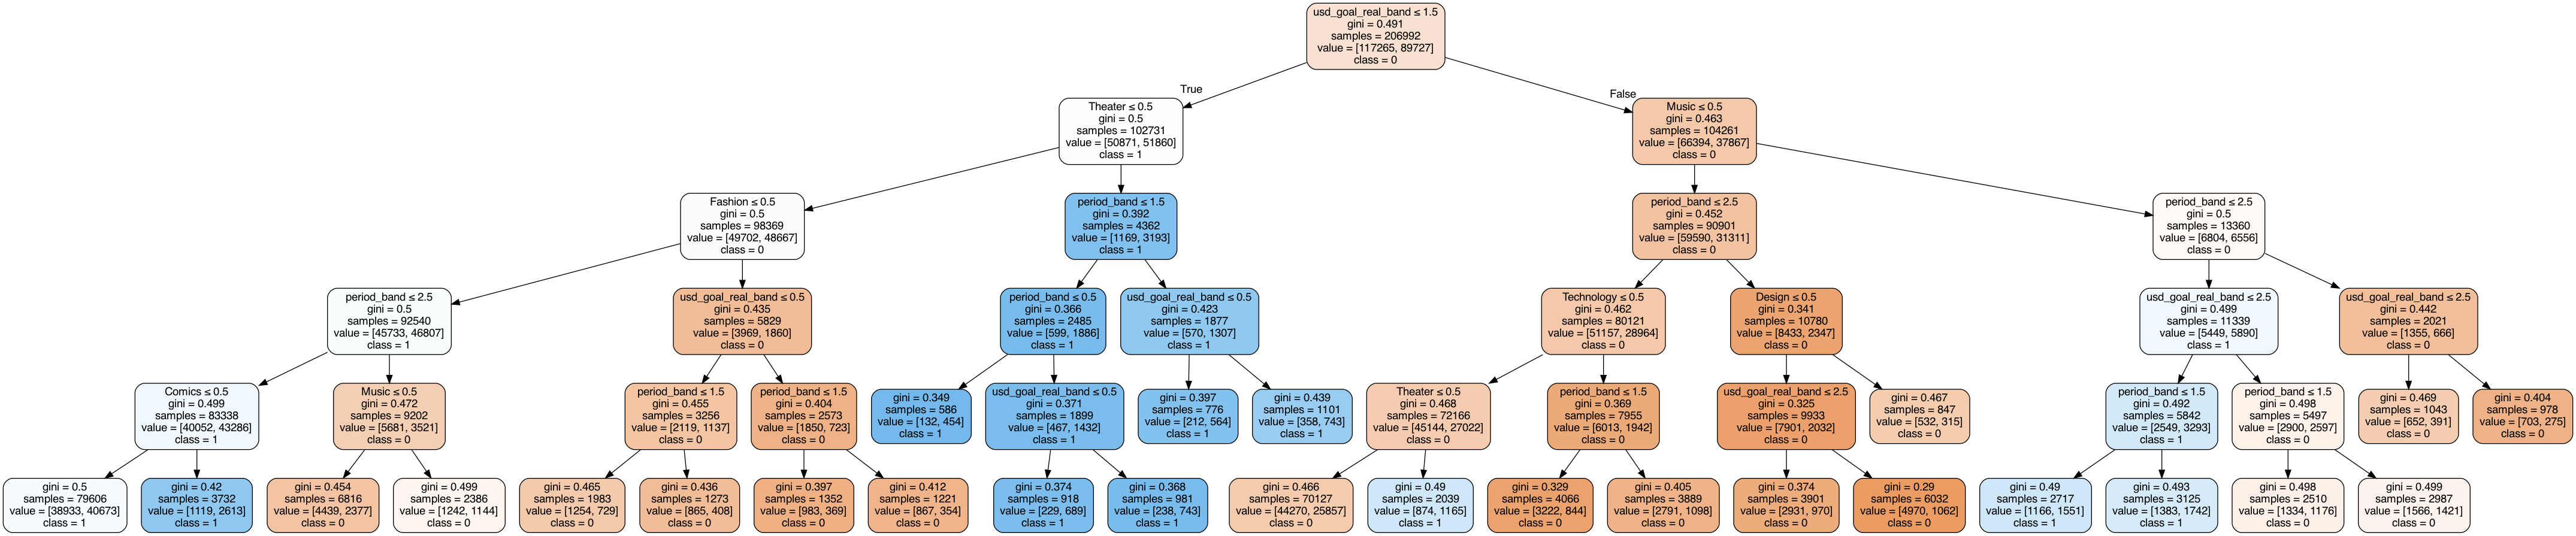

In [37]:
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,
               feature_names=df_kickstarter.drop(["state", "usd_goal_real", "period"], axis=1).columns,
               class_names=["0", "1"],
               filled=True, rounded=True, special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

[0.16736269 0.42175145 0.         0.04956423 0.         0.
 0.00848455 0.07422147 0.         0.         0.         0.
 0.10848317 0.         0.         0.04724735 0.1228851 ]


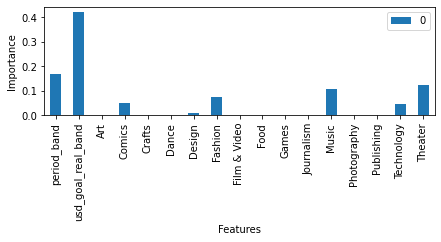

In [38]:
print(clf.feature_importances_)
pd.DataFrame(clf.feature_importances_, index=df_kickstarter.drop(["state", "usd_goal_real", "period"], axis=1).columns).plot.bar(figsize=(7,2))
plt.ylabel("Importance")
plt.xlabel("Features")
plt.show()

In [39]:
y_est = clf.predict(X_test)
y_est_proba = clf.predict_proba(X_test)
print("対数尤度 = {:.3f}".format(-log_loss(y_test, y_est_proba, normalize=False)))
print("正答率 = {:.3f}%".format(100 * accuracy_score(y_test, y_est)))

対数尤度 = -58336.643
正答率 = 59.722%


In [40]:
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_est), index=["正解 = failed", "正解 = successful"], columns=["予測値 = failed", "予測値 = successful"])
display(conf_mat)

,予測値 = failed,予測値 = successful
正解 = failed,31343,19111
正解 = successful,16620,21637


In [41]:
# precision, recall, f1を計算

precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_est)

print('適合率（Precision） = {:.3f}%'.format(100 * precision[1]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[1]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[1]))

適合率（Precision） = 53.100%
再現率（Recall） = 56.557%
F1値（F1-score） = 54.774%


### max_depth = 5の結果
- 正答率 = 59.722%
- 適合率（Precision） = 53.100%
- 再現率（Recall） = 56.557%
- F1値（F1-score） = 54.774%

### bandなし + 標準化 + 決定木

In [42]:
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
y = df_kickstarter["state"].values

# bandを使わず，usd_goal_real, periodを標準化して予測
X = df_kickstarter.drop(["state", "usd_goal_real_band", "period_band"], axis=1).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)

X_train[:, 0] = stdsc.fit_transform(X_train[:, 0].reshape(-1, 1)).reshape(1, -1) # usd_goal_realの標準化
X_test[:, 0] = stdsc.transform(X_test[:, 0].reshape(-1, 1)).reshape(1, -1) 

X_train[:, 1] = stdsc.fit_transform(X_train[:, 1].reshape(-1, 1)).reshape(1, -1)  # periodの標準化
X_test[:, 1] = stdsc.transform(X_test[:, 1].reshape(-1, 1)).reshape(1, -1) 


clf = DecisionTreeClassifier(criterion="gini", max_depth=None, min_samples_split=500, min_samples_leaf=500, random_state=1234)
clf.fit(X_train, y_train)
print("score = ", clf.score(X_train, y_train))


score =  0.6372710056427302


- max_depth=Noneとすると結果の木が描画できなかった．

[0.31674991 0.28966591 0.00211038 0.04769778 0.02188907 0.00346645
 0.00944888 0.03416349 0.0195871  0.01349913 0.01611604 0.00722384
 0.08806887 0.01374725 0.01648818 0.04036407 0.05971366]


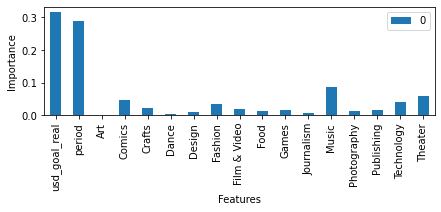

In [43]:
print(clf.feature_importances_)
pd.DataFrame(clf.feature_importances_, index=df_kickstarter.drop(["state", "usd_goal_real_band", "period_band"], axis=1).columns).plot.bar(figsize=(7,2))
plt.ylabel("Importance")
plt.xlabel("Features")
plt.show()

In [44]:
y_est = clf.predict(X_test)
y_est_proba = clf.predict_proba(X_test)
print("対数尤度 = {:.3f}".format(-log_loss(y_test, y_est_proba, normalize=False)))
print("正答率 = {:.3f}%".format(100 * accuracy_score(y_test, y_est)))

対数尤度 = -56664.473
正答率 = 63.398%


In [45]:
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_est), index=["正解 = failed", "正解 = successful"], columns=["予測値 = failed", "予測値 = successful"])
display(conf_mat)

,予測値 = failed,予測値 = successful
正解 = failed,38140,12314
正解 = successful,20156,18101


In [46]:
# precision, recall, f1を計算

precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_est)

print('適合率（Precision） = {:.3f}%'.format(100 * precision[1]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[1]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[1]))

適合率（Precision） = 59.513%
再現率（Recall） = 47.314%
F1値（F1-score） = 52.717%


### period, usd_goal_realを標準化 + 決定木
- 正答率 = 63.398%
- 適合率（Precision） = 59.513%
- 再現率（Recall） = 47.314%
- F1値（F1-score） = 52.717%


- 標準化したusd_goal_real, periodを使った方がbandを使うより良い結果が得られた．

## RandomForest

### band + RandomForest

In [47]:
y = df_kickstarter["state"].values
# bandを使って予測
X = df_kickstarter.drop(["state", "usd_goal_real", "period"], axis=1).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)

In [48]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=10, max_depth=None, criterion="gini",
                                                 min_samples_leaf=1000, min_samples_split=1000, random_state=1234)
clf.fit(X_train, y_train)
print("score=", clf.score(X_train, y_train))

score= 0.6224926567210327


In [49]:
y_est = clf.predict(X_test)
y_est_proba = clf.predict_proba(X_test)
print("対数尤度 = {:.3f}".format(-log_loss(y_test, y_est_proba, normalize=False)))
print("正答率 = {:.3f}%".format(100 * accuracy_score(y_test, y_est)))

対数尤度 = -57569.571
正答率 = 62.222%


In [50]:
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_est), index=["正解 = failed", "正解 = successful"], columns=["予測値 = failed", "予測値 = successful"])
display(conf_mat)

,予測値 = failed,予測値 = successful
正解 = failed,38484,11970
正解 = successful,21543,16714


In [51]:
# precision, recall, f1を計算
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_est)

print('適合率（Precision） = {:.3f}%'.format(100 * precision[1]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[1]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[1]))

適合率（Precision） = 58.269%
再現率（Recall） = 43.689%
F1値（F1-score） = 49.937%


### band + RandomForestの結果
- 正答率 = 62.222%
- 適合率（Precision） = 58.269%
- 再現率（Recall） = 43.689%
- F1値（F1-score） = 49.937%

### bandなし + 標準化 + RandomForest

In [52]:
y = df_kickstarter["state"].values
# bandを使わず，usd_goal_real, periodを標準化して予測
X = df_kickstarter.drop(["state", "usd_goal_real_band", "period_band"], axis=1).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)

X_train[:, 0] = stdsc.fit_transform(X_train[:, 0].reshape(-1, 1)).reshape(1, -1) # usd_goal_realの標準化
X_test[:, 0] = stdsc.transform(X_test[:, 0].reshape(-1, 1)).reshape(1, -1) 

X_train[:, 1] = stdsc.fit_transform(X_train[:, 1].reshape(-1, 1)).reshape(1, -1)  # periodの標準化
X_test[:, 1] = stdsc.transform(X_test[:, 1].reshape(-1, 1)).reshape(1, -1) 

In [53]:
clf = RandomForestClassifier(n_estimators=10, max_depth=None, criterion="gini",
                                                 min_samples_leaf=1000, min_samples_split=1000, random_state=1234)
clf.fit(X_train, y_train)
print("score=", clf.score(X_train, y_train))

score= 0.6284059287315452


In [54]:
y_est = clf.predict(X_test)
y_est_proba = clf.predict_proba(X_test)
print("対数尤度 = {:.3f}".format(-log_loss(y_test, y_est_proba, normalize=False)))
print("正答率 = {:.3f}%".format(100 * accuracy_score(y_test, y_est)))

対数尤度 = -57046.838
正答率 = 62.943%


In [55]:
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_est), index=["正解 = failed", "正解 = successful"], columns=["予測値 = failed", "予測値 = successful"])
display(conf_mat)

,予測値 = failed,予測値 = successful
正解 = failed,39510,10944
正解 = successful,21930,16327


In [56]:
# precision, recall, f1を計算
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_est)

print('適合率（Precision） = {:.3f}%'.format(100 * precision[1]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[1]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[1]))

適合率（Precision） = 59.869%
再現率（Recall） = 42.677%
F1値（F1-score） = 49.832%


### period, usd_goal_realを標準化 + RandomForestの結果
- 正答率 = 62.943%
- 適合率（Precision） = 59.869%
- 再現率（Recall） = 42.677%
- F1値（F1-score） = 49.832%

- 標準化したデータを使った方が良い結果が得られた．

## AdaBoost

### band + AdaBoost + RandomForest

In [57]:
y = df_kickstarter["state"].values
# bandを使って予測
X = df_kickstarter.drop(["state", "usd_goal_real", "period"], axis=1).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)

In [58]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier


clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=None,
                                                                                 min_samples_leaf=1000,
                                                                                 min_samples_split=1000, 
                                                                                 random_state=1234,
                                                                                 criterion="gini"),
                                           n_estimators=10, random_state=1234)
clf.fit(X_train, y_train)
print("score=", clf.score(X_train, y_train))

score= 0.6261981139367705


In [59]:
y_est = clf.predict(X_test)
y_est_proba = clf.predict_proba(X_test)
print("対数尤度 = {:.3f}".format(-log_loss(y_test, y_est_proba, normalize=False)))
print("正答率 = {:.3f}%".format(100 * accuracy_score(y_test, y_est)))

conf_mat = pd.DataFrame(confusion_matrix(y_test, y_est), index=["正解 = failed", "正解 = successful"], columns=["予測値 = failed", "予測値 = successful"])
display(conf_mat)

precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_est)

print('適合率（Precision） = {:.3f}%'.format(100 * precision[1]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[1]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[1]))

対数尤度 = -60616.868
正答率 = 62.573%


,予測値 = failed,予測値 = successful
正解 = failed,38640,11814
正解 = successful,21388,16869


適合率（Precision） = 58.812%
再現率（Recall） = 44.094%
F1値（F1-score） = 50.400%


[0.2333801  0.28821037 0.03909731 0.05131225 0.01800383 0.08039382
 0.00884077 0.02562419 0.03837743 0.01692729 0.02105825 0.0229411
 0.05928604 0.01917632 0.03551888 0.01813022 0.02372182]


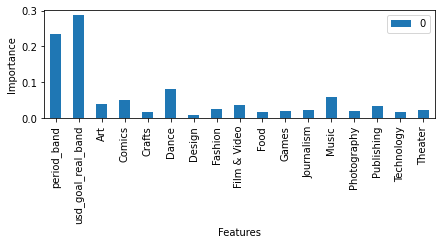

In [60]:
print(clf.feature_importances_)
pd.DataFrame(clf.feature_importances_, index=df_kickstarter.drop(["state", "usd_goal_real", "period"], axis=1).columns).plot.bar(figsize=(7,2))
plt.ylabel("Importance")
plt.xlabel("Features")
plt.show()

### 結果
- 正答率 = 62.573%
- 適合率（Precision） = 58.812%
- 再現率（Recall） = 44.094%
- F1値（F1-score） = 50.400%

### bandなし + 標準化 + AdaBoost + RandomForest

In [61]:
y = df_kickstarter["state"].values
# bandを使わず，usd_goal_real, periodを標準化して予測
X = df_kickstarter.drop(["state", "usd_goal_real_band", "period_band"], axis=1).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)

X_train[:, 0] = stdsc.fit_transform(X_train[:, 0].reshape(-1, 1)).reshape(1, -1) # usd_goal_realの標準化
X_test[:, 0] = stdsc.transform(X_test[:, 0].reshape(-1, 1)).reshape(1, -1) 

X_train[:, 1] = stdsc.fit_transform(X_train[:, 1].reshape(-1, 1)).reshape(1, -1)  # periodの標準化
X_test[:, 1] = stdsc.transform(X_test[:, 1].reshape(-1, 1)).reshape(1, -1) 

In [62]:
clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=None,
                                                                                 min_samples_leaf=1000,
                                                                                 min_samples_split=1000, 
                                                                                 random_state=1234,
                                                                                 criterion="gini"),
                                           n_estimators=10, random_state=1234)
clf.fit(X_train, y_train)
print("score=", clf.score(X_train, y_train))

score= 0.6461988869135039


In [63]:
y_est = clf.predict(X_test)
y_est_proba = clf.predict_proba(X_test)
print("対数尤度 = {:.3f}".format(-log_loss(y_test, y_est_proba, normalize=False)))
print("正答率 = {:.3f}%".format(100 * accuracy_score(y_test, y_est)))

conf_mat = pd.DataFrame(confusion_matrix(y_test, y_est), index=["正解 = failed", "正解 = successful"], columns=["予測値 = failed", "予測値 = successful"])
display(conf_mat)

precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_est)

print('適合率（Precision） = {:.3f}%'.format(100 * precision[1]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[1]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[1]))

対数尤度 = -60374.279
正答率 = 63.674%


,予測値 = failed,予測値 = successful
正解 = failed,38163,12291
正解 = successful,19934,18323


適合率（Precision） = 59.852%
再現率（Recall） = 47.895%
F1値（F1-score） = 53.210%


[0.56063871 0.2536505  0.00467    0.01383908 0.0156367  0.02435436
 0.00564723 0.01034031 0.0213022  0.01292558 0.00561257 0.00924323
 0.02170463 0.00594889 0.01325981 0.00922983 0.01199637]


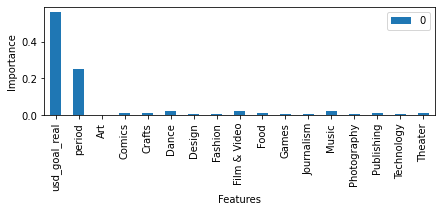

In [64]:
print(clf.feature_importances_)
pd.DataFrame(clf.feature_importances_, index=df_kickstarter.drop(["state", "usd_goal_real_band", "period_band"], axis=1).columns).plot.bar(figsize=(7,2))
plt.ylabel("Importance")
plt.xlabel("Features")
plt.show()

### 結果
- 正答率 = 63.674%
- 適合率（Precision） = 59.852%
- 再現率（Recall） = 47.895%
- F1値（F1-score） = 53.210%

- AdaBoostの場合でも標準化したデータを使った方が予測結果が良くなった.

## NN

### bandなし + 標準化 + NN

In [67]:
import tensorflow as tf
from tensorflow import keras

y = df_kickstarter["state"].values
# bandを使わず，usd_goal_real, periodを標準化して予測
X = df_kickstarter.drop(["state", "usd_goal_real_band", "period_band"], axis=1).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)

X_train[:, 0] = stdsc.fit_transform(X_train[:, 0].reshape(-1, 1)).reshape(1, -1) # usd_goal_realの標準化
X_test[:, 0] = stdsc.transform(X_test[:, 0].reshape(-1, 1)).reshape(1, -1) 

X_train[:, 1] = stdsc.fit_transform(X_train[:, 1].reshape(-1, 1)).reshape(1, -1)  # periodの標準化
X_test[:, 1] = stdsc.transform(X_test[:, 1].reshape(-1, 1)).reshape(1, -1) 

from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [68]:
X.shape

(295703, 17)

### Adam

In [72]:
from tensorflow.compat.v1.keras import Sequential
from tensorflow.compat.v1.keras.layers import Dense, Dropout, Activation
from tensorflow.compat.v1.keras.optimizers import SGD,RMSprop, Adagrad, Adadelta, Adam

model = Sequential()
model.add(Dense(25, activation='relu', input_dim=X.shape[1]))
model.add(Dense(30, activation='relu', input_dim=25))
model.add(Dense(2, activation='sigmoid'))

adam = Adam(lr=0.01)

model.compile(loss='binary_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])


Train on 206992 samples, validate on 88711 samples
Epoch 1/20
206992/206992 [==============================] - 19s 90us/sample - loss: 0.6493 - acc: 0.6211 - val_loss: 0.6531 - val_acc: 0.6189
Epoch 2/20
206992/206992 [==============================] - 19s 90us/sample - loss: 0.6469 - acc: 0.6241 - val_loss: 0.6458 - val_acc: 0.6246
Epoch 3/20
206992/206992 [==============================] - 18s 87us/sample - loss: 0.6463 - acc: 0.6245 - val_loss: 0.6452 - val_acc: 0.6243
Epoch 4/20
206992/206992 [==============================] - 18s 87us/sample - loss: 0.6463 - acc: 0.6248 - val_loss: 0.6494 - val_acc: 0.6161
Epoch 5/20
206992/206992 [==============================] - 18s 87us/sample - loss: 0.6461 - acc: 0.6250 - val_loss: 0.6464 - val_acc: 0.6283
Epoch 6/20
206992/206992 [==============================] - 19s 91us/sample - loss: 0.6458 - acc: 0.6256 - val_loss: 0.6472 - val_acc: 0.6270
Epoch 7/20
206992/206992 [==============================] - 18s 88us/sample - loss: 0.6458 - acc:

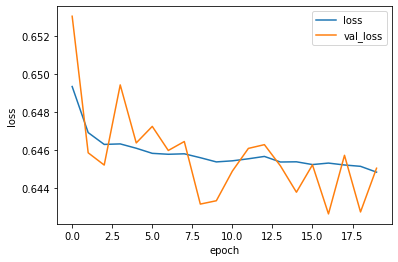

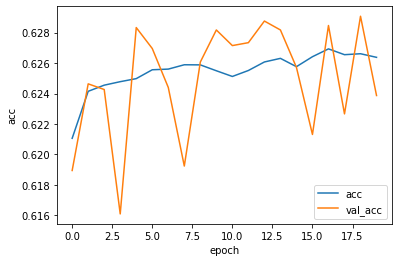

In [73]:
# 計算の実行
fit = model.fit(X_train, y_train,
          epochs=20,
          batch_size=10,validation_data=(X_test, y_test))

df = pd.DataFrame(fit.history)

# グラフ化
df[["loss", "val_loss"]].plot()
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

df[["acc", "val_acc"]].plot()
plt.ylabel("acc")
plt.xlabel("epoch")
# plt.ylim([0,1.0])
plt.show()

In [79]:
print("正答率 = {:.3f}%".format(100 * df["acc"].mean()))

正答率 = 62.548%


# まとめ
- 全体を通して，標準化したusd_goal_real, periodを使った方が良い予測結果が得られた.
- 各モデルの正答率の結果を以下にまとめる．
 - 決定木: 63.398%
 - RandomForest: 62.943%
 - AdaBoost(RandomForest): 62.573%
 - NN(Adam): 62.548%

各モデルの結果はほとんど変わらなかったが，計算時間や結果の理解のしやすさを考えると，決定木が最適なモデルだったと考えられる．